<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./2_2_acquire_S6_full_cycle.ipynb" target="_blank"><< Acquiring a full Poseidon-4 cycle</a>    

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-olci/HEAD?urlpath=%2Ftree%2F2_S6_advanced%2F2_3_S6_Waveforms-coasts.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn Sentinel-6: Advanced</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
Users should review the following notebooks for more information on setting up a credentials files for using the eumdac python library to retrieve Poseidon-4 data from the Data Store:
    
- **<a href="../1_S6_introductory/1_1_S6_data_access_Data_Store.ipynb">1_1_S6_data_access_Data_Store.ipynb</a>**

</div>
<hr>

# 2.3 Sentinel-6 waveforms for two different modes close to coastal features

### Data used

| Product Description  | Data Store collection ID| Product Navigator | 
|:--------------------:|:-----------------------:|:-------------:|
| Sentinel-6 Poseidon-4 Altimetry level-1B Low Resolution - Reprocessed | EO:EUM:DAT:0237 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:0237?query=0237&s=advanced" target="_blank">link</a> |
| Sentinel-6 Poseidon-4 Altimetry level-1B High Resolution - Reprocessed | EO:EUM:DAT:0238 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:0238?query=0238&s=advanced" target="_blank">link</a> |


### Learning outcomes
**EXPAND**

At the end of this notebook you will know;
* <font color="#138D75">**Download**</font> Sentinel-6 Poseidon-4 Level-1B low- and high-resolution products using the EUMETSAT Data Store API client (`eumdac`)
* <font color="#138D75">**Compare**</font> the low and high resolution waveforms

### Outline
**EXPAND**

As part of Copernicus, EUMETSAT operates the Poseidon-4 altimeter on Sentinel-6.

Waveforms are the fundamental signal that altimeters receive, and from which they derive all their information about the ocean surface. The shape of a waveform is determined by how a radar pulse interacts with the Earth's surface. Much more information on waveforms can be found here:

http://www.altimetry.info/radar-altimetry-tutorial/how-altimetry-works/from-radar-pulse-to-altimetry-measurements/

<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>

0. [Defining functions](#section0)
1. [Acquiring Sentinel-6 data from the EUMETSAT Data Store](#section1)
1. [Reading, subsetting and processing Sentinel-6 data](#section2)
1. [Plotting the waveforms in a geographical context](#section3)
1. [Comparing the waveforms in 3D](#section4)
1. [Along track evolution of the waveform](#section5)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
import os                                      # a library that allows us access to basic operating system commands
import json                                    # a library that helps us make JSON format files
import numpy as np                             # a library that lets us work with arrays
import xarray as xr                            # a powerful library that helps us work with multi-dimensional arrays
import matplotlib.pyplot as plt                # a library the provides plotting capability
import cartopy                                 # a library that supports mapping and projection
import cartopy.io.img_tiles as cimgt           # a subcomponent of cartopy that plots land tiles
import shutil                                  # a library that allows us access to basic operating system commands
import zipfile                                 # a library that support zipping/unzipping files
import eumdac                                  # a tool that helps us download via the eumetsat/data-store
from matplotlib.animation import FuncAnimation # a library that supports animation
from IPython.core.display import HTML          # a library that supports HTML functions
from PIL import Image                          # a library that supports image import and display functions

We will also create a directory to download our data to.

In [2]:
# Create a download directory for our Sentinel-6 products
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

The cell below will set some parameters to control how this notebook runs. 

Our test region is close to the Port of Taher 
in Algeria, 36.8132°N, 5.8517°E


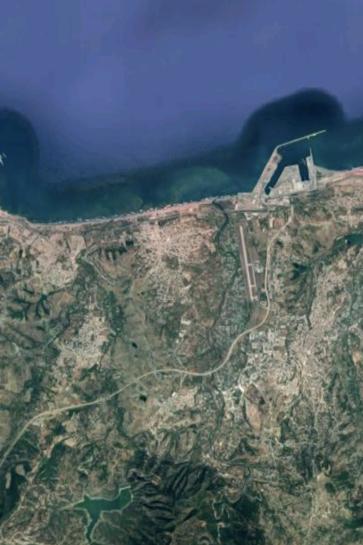

In [3]:
# If you have already downloaded the data, you can set this to false. But if you are
# runnning for the first time this should be true (Default)
download_data = True

# Manually setting the track direction (though this can be determined from the files)
track_direction = 0 # descending = 0, ascending = 1

# -------------------
# Select a test case
# -------------------
Fort_Boyard = False

if Fort_Boyard:
    print("Our test region is Fort Boyard, a fort situated in")
    print("the coastal waters of France, at 46°N, -1.214°E")
    print("(Credit; Guillaume de Germain)")
    region = [358.7, 358.9, 45.9, 46.1] # W,E,S,N
    region_focus = [-1.214, 46]
    display(Image.open('../img/Fort_Boyard.png'))
else:
    print("Our test region is close to the Port of Taher ")
    print("in Algeria, 36.8132°N, 5.8517°E")
    region = [5.75, 5.95, 36.7, 36.9] # W,E,S,N
    region_focus = [5.8517, 36.8132]
    display(Image.open('../img/Algeria_Coast.png'))

The parameters below are constants that control plotting and subsampling.

In [4]:
# Set default figure font size
plt.rcParams.update({'font.size': 16})
# Set resolution of the figures in dpi 
dpi = 150
# plot pad; for a wider view
pad = 5
# Information needed to use a tiled background map.
tiler = cimgt.Stamen('terrain-background')
# Tile map level of zoom
zoom = 12
# we will restrict our data plotting to a very small area of about 10 index points
# using this epsilon, the distance between two consecutive points at the focus latitude 
epsilon = 0.012
# information used to compute the angle of the track with respect to parallels 
cwin = 2

<div class="alert alert-warning" role="alert">

## <a id='section0'></a>0. Defining functions
[Back to top](#TOC_TOP)

</div>

In [5]:
def process_S6_track(S6_vars, cwin, earth_radius=6371000):
    '''
    this function computes the angle of the track by using a window of 'cwin' length and basic trigonometry
    we will need it to plot the data across the track some cells below
    '''
    dLon = np.radians(S6_vars["lon_20"][cwin:] - S6_vars["lon_20"][:-cwin])
    dLat = np.radians(S6_vars["lat_20"][cwin:] - S6_vars["lat_20"][:-cwin])
    # distance in meters along longitude ending at i (NB. dLon in radians) 
    dx_before = earth_radius * dLon * np.cos(np.radians(S6_vars["lat_20"][cwin:]))
    # distance in meters along latitude, between i+1 and i (NB. dLat in radians)
    dy = earth_radius * dLat

    # angle relative to the equator; 
    # it depends if the track is ascending (from South pole to North, latitudes increasing) 
    # or descending (from North to South)
    angle = np.arctan2(dy, dx_before)

    if track_direction == 0:
        angle = np.arctan2(dy, dx_before) + np.pi

    # angle has 2 points less than the lat_20 & lon_20 array - we add indexes so as to be able to use them together, 
    # even if last two points won't have a valid "angle" value
    angle = angle.pad(time=(0, cwin))
    
    return angle

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Acquiring Sentinel-6 data from the EUMETSAT Data Store
[Back to top](#TOC_TOP)

</div>

We are going to retrieve the Sentinel-6 reprocessed level-1B data from the EUMETSAT Data Store. Collections are stored according to their `collectionID`, which are as follows (as specified in the *Data Used* section above);
* for level-1B low-resolution products; `EO:EUM:DAT:0237`
* for level-1B high-resolution products; `EO:EUM:DAT:0238`

We will store these in a list...

In [6]:
collectionIDs = ["EO:EUM:DAT:0237", "EO:EUM:DAT:0238"]

We will also provide the relevant products we want from this collection, stored in `productIDs`, which in this case is one product from each collection.

In [7]:
productIDs = [
    'S6A_P4_1B_LR______20220410T013454_20220410T023107_20220522T101118_3373_052_070_035_EUM__REP_NT_F06.SEN6',
    'S6A_P4_1B_HR______20220410T013454_20220410T023107_20220522T154619_3373_052_070_035_EUM__REP_NT_F06.SEN6'
]

To access Sentinel-6 data from the <a href="https://data.eumetsat.int">EUMETSAT Data Store</a>, we will use the EUMETSAT Data Access Client (`eumdac`). If you are working with the recommended Anaconda Python distribution and used the supplied environment file (environment.yml) to build this python environment (as detailed in the README), you will already have installed this. If not, you can install eumdac using;

`conda install -c eumetsat eumdac`

However, you can also find the source code on the <a href="https://gitlab.eumetsat.int/eumetlab/data-services/eumdac">EUMETSAT gitlab</a>. Please visit the EUMETSAT user support confluence spaces for the the <a href="https://eumetsatspace.atlassian.net/wiki/spaces/DSDS/overview">Data Store</a> and <a href="https://eumetsatspace.atlassian.net/wiki/spaces/EUMDAC/overview">eumdac</a> for more information.

In order to allow us to download data from the Data Store via API, we need to provide our credentials. We can do this in two ways; either by creating a file called `.eumdac_credentials` in our home directory (*option 1 - recommended*) or by supplying our credentials directly in this script (*option 2*). 

<div class="alert alert-block alert-success">

#### Option 1: creating  `.eumdac_credentials` in your home directory

For most computer systems the home directory can be found at the path \user\username, /users/username, or /home/username depending on your operating system. In this file we need to add the following information exactly as follows;

```
{
"consumer_key": "<your_consumer_key>",
"consumer_secret": "<your_consumer_secret>"
}
```

You must replace `<your_consumer_key>` and `<your_consumer_secret>` with the information you extract from https://api.eumetsat.int/api-key/. You will need a <a href="https://eoportal.eumetsat.int/">EUMETSAT Earth Observation Portal account</a> to access this link, and in order to see the information you must click the "Show hidden fields" button at the bottom of the page.

*Note: your key and secret are permanent, so you only need to do this once, but you should take care to never share them*

Make sure to save the file without any kind of extension. Once you have done this, you can read in your credentials using the commands in the following cell with `file_credentials = True`. These credentials will be used to generate a time-limited token, which will refresh itself when it expires.
    
</div>
    
<div class="alert alert-danger" role="alert">

#### Option 2: Generating a token directly by entering your key and secret in the notebook as follows*
   
Alternatively you can enter your credentials directly in the notebook by updating the following line with your user specifi information and setting `file_credentials = False`.

```
token = eumdac.AccessToken(("consumer_key", "consumer_secret"))
```

However, while this method is convenient in the short term, but is not really recommended as you have to put your key and secret in this notebook, and run the risk of accidentally sharing them. This method also requires you to authenticate on a notebook-by-notebook basis.
    
<div>

In [8]:
# load credentials
file_credentials = True

if file_credentials == True:
    with open(os.path.join(os.path.expanduser("~"),'.eumdac_credentials')) as json_file:
        credentials = json.load(json_file)
        token = eumdac.AccessToken((credentials['consumer_key'], credentials['consumer_secret']))
        print(f"This token '{token}' expires {token.expiration}")
else:
    # see below for more information
    token = eumdac.AccessToken(("consumer_key", "consumer_secret"))

This token '0949572e-57e8-3ad1-8a0c-351fa3059419' expires 2022-09-27 11:49:40.641416


Now we have a token, we can create an instance of the EUMETSAT Data Store.

In [9]:
datastore = eumdac.DataStore(token)

Now we will loop through the collections and products to get the items that we need.

In [10]:
# Download the product - beware what is download_data value up in the notebook (if False, you won't download anything)
if download_data:
    for collectionID, productID in zip(collectionIDs, productIDs):
        selected_product = datastore.get_product(product_id=productID, collection_id=collectionID)
        with selected_product.open() as fsrc, open(os.path.join(download_dir, fsrc.name), mode='wb') as fdst:
            print(f'Downloading {fsrc.name}')
            shutil.copyfileobj(fsrc, fdst)
            print(f'Download of product {fsrc.name} finished.')

        # Unzip the product
        with zipfile.ZipFile(fdst.name, 'r') as zip_ref:
            for file in zip_ref.namelist():
                if file.startswith(str(selected_product)):
                    zip_ref.extract(file, download_dir)
            print(f'Unzipping of product {selected_product} finished.')
         # Clean up
        os.remove(fdst.name)

Download of product S6A_P4_1B_LR______20220410T013454_20220410T023107_20220522T101118_3373_052_070_035_EUM__REP_NT_F06.SEN6.zip finished.
Unzipping of product S6A_P4_1B_LR______20220410T013454_20220410T023107_20220522T101118_3373_052_070_035_EUM__REP_NT_F06.SEN6 finished.
Download of product S6A_P4_1B_HR______20220410T013454_20220410T023107_20220522T154619_3373_052_070_035_EUM__REP_NT_F06.SEN6.zip finished.
Unzipping of product S6A_P4_1B_HR______20220410T013454_20220410T023107_20220522T154619_3373_052_070_035_EUM__REP_NT_F06.SEN6 finished.


If all went well, you should now find a new directory (by default called `products`) in the same folder as this notebook. This should contain two Sentinel-6 reprocessed products, one level-1B low-resolution and one level-1B high-resolution.

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Reading, subsetting and processing Sentinel-6 data
[Back to top](#TOC_TOP)

</div>

We will read and extract data from the L1B files. Note that you can have a look before at the L2 file, to check the direction of the track (south pole to north or the reverse), and also to check if the tide is not very low - in this particular case, measurements could be on wet sand rather than water at very low tides. Those variables are provided within the L2 file, not the L1B for S6.

We will start by working with the low-resolution file.

In [11]:
# define a dictionary to store our variables
S6_vars = {}

for productID in productIDs:
    input_file = os.path.join(download_dir, productID, 'measurement.nc')
    # Since we consider looking at both versions of the file,
    # we define "res" as HR or LR (to be used twice later on)
    # extract either HR or LR from the file name (string)
    res = productID[10:12]

    # define sub-dictionaries for each product "LR/HR"
    S6_vars[res] = {}

    #data are ordered in groups; you have to read each group as a separate dataset. 
    nc = xr.open_dataset(input_file)
    nc20ku = xr.open_dataset(input_file, group='data_20/ku')

    #there is one (and only one) of the variables we will use which is different in HR and in LR files
    # for easiness of use afterwards, we call it by the same name 
    if res=='HR':
        S6_vars[res]["samples"] = nc.variables['samples_ov']
    else:
        S6_vars[res]["samples"] = nc.variables['samples']

    # Extract data only in the lon/lat box searched
    subsetnc20ku = nc20ku.sel(time=((nc20ku.variables['longitude'] > region[0]) 
                                  & (nc20ku.variables['longitude'] < region[1]) 
                                  & (nc20ku.variables['latitude'] > region[2]) 
                                  & (nc20ku.variables['latitude'] < region[3])))
    S6_vars[res]["subset"] = subsetnc20ku

    nc20ku.close()
    nc.close()
        
    # subset out variables
    S6_vars[res]["lat_20"] = subsetnc20ku.variables['latitude']
    S6_vars[res]["lon_20"] = subsetnc20ku.variables['longitude']
    S6_vars[res]["time"] = subsetnc20ku.variables['time']
    S6_vars[res]["waveforms_20hz_ku"] = subsetnc20ku.variables['power_waveform']
    
    # calculate a few variables
    S6_vars[res]["angle"] = process_S6_track(S6_vars[res], cwin)
    S6_vars[res]["samples2"], S6_vars[res]["time2"] = \
      np.meshgrid(S6_vars[res]["samples"], S6_vars[res]["time"])
    
    S6_vars[res]["x"] = []
    S6_vars[res]["y"] = []

    # we will plot the waveform in color with respect to sample (in absissa) and index (in ordinate), 
    # but we also want to look at it in a geographical context (which is not meant for)
    # For this, we place the index 128 (on 256) in the middle of the plot on the actual track 
    # (NB. it is purely cosmetic) we compute the new absissa and ordinate (x and y) with respect to 
    # lon and lat, with a tilt (angle computed in a function above, coefficients empirical, 1 increment ~ 0.05° )
    for i in range(0,256):
        S6_vars[res]["x"].append(S6_vars[res]["lon_20"]-((128-i)/255)*0.05*np.cos(np.radians(S6_vars[res]["angle"])))
        S6_vars[res]["y"].append(S6_vars[res]["lat_20"]-((128-i)/255)*np.sin(np.radians(S6_vars[res]["angle"])))

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Plotting the waveforms in a geographical context
[Back to top](#TOC_TOP)

</div>

Plot of the track, to have a look at where we are (enlarge the set_extent to have a broader view)

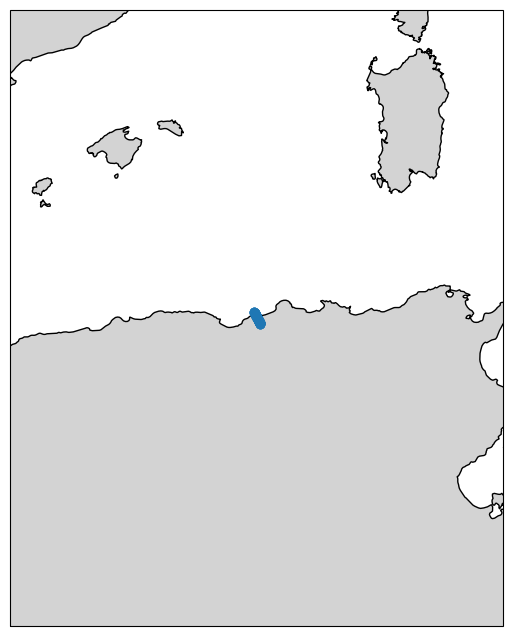

In [12]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=cartopy.crs.PlateCarree(), aspect=1.25)

# plot the data on a map
tracks = ax.scatter(S6_vars["LR"]["lon_20"], S6_vars["LR"]["lat_20"])
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=0)
ax.set_extent([region[0]-pad, region[1]+pad, region[2]-pad, region[3]+pad])

We will plot the waveforms' power as a color plot along time and samples
Note that we could have used pcolormesh for this and would not have needed the meshgrid regridding, but we will need the scatter plotting afterwards and it would not have worked if the three x, y and c do not have the exact same dimensions. 

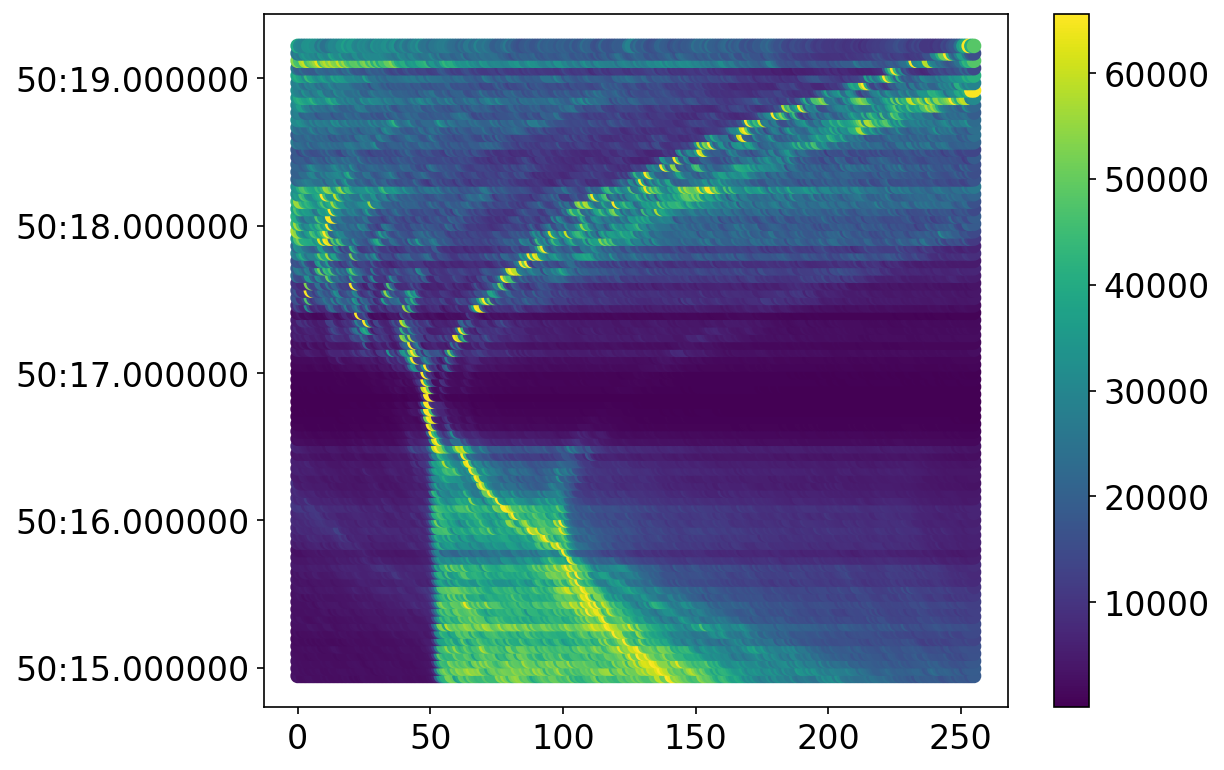

In [13]:
fig = plt.figure(figsize=(8, 6), dpi=dpi)
ax = plt.subplot(1,1,1)
# useful plot but not fitting our specific need (to overlay this on a map). 
# Most often this is the kind of plot used, though.
p1 = ax.scatter(S6_vars["LR"]["samples2"], S6_vars["LR"]["time2"], c=S6_vars["LR"]["waveforms_20hz_ku"])

#colorbar
cbar = plt.colorbar(p1)

Now we (arbitrarilly) define a step in lon, lat between two samples (those are supposed to be the effect of the radar wave reflection along time, not across the track, but we want to have a look at the waveforms in their geographical context).

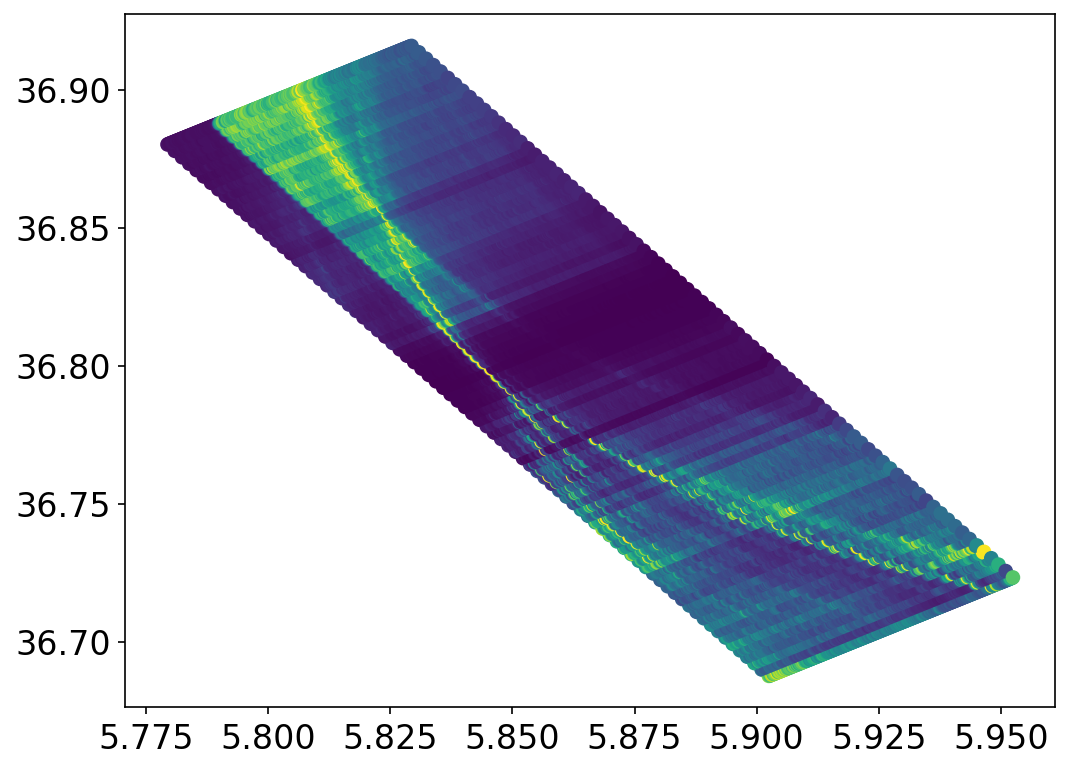

In [14]:
fig = plt.figure(figsize=(8, 6), dpi=dpi)
ax = plt.subplot(1,1,1)
p1 = ax.scatter(S6_vars["LR"]["x"], S6_vars["LR"]["y"], c=S6_vars["LR"]["waveforms_20hz_ku"][:, 0:256].T,
                vmin=0., vmax=65534)

Plot this on a basic map - note that this is *_not_* a real representation of the geographical width of the radar beam.

Text(0.5, 1.0, 'LR waveform samples on a geographic context')

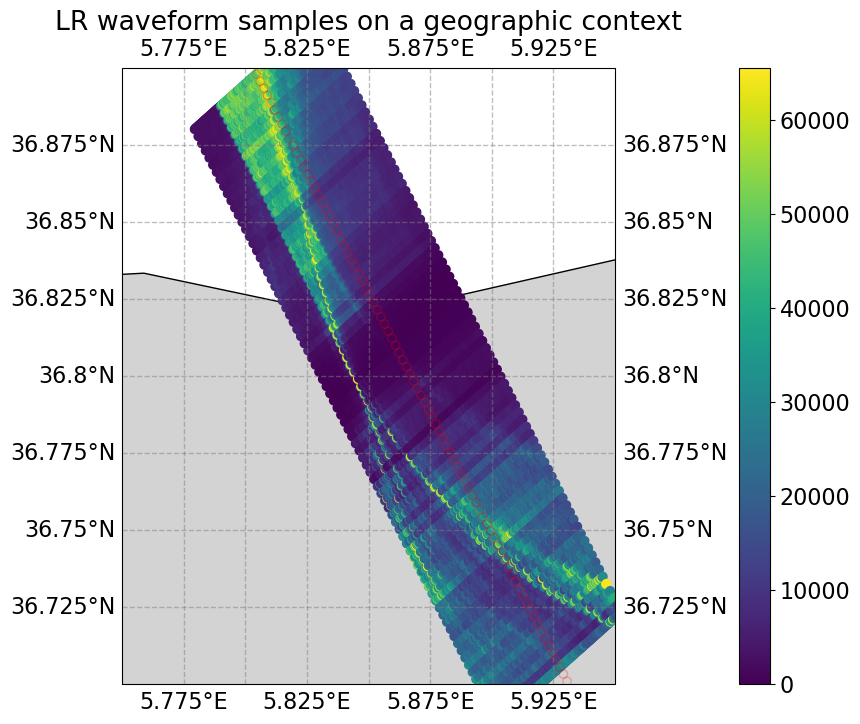

In [15]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=cartopy.crs.PlateCarree(), aspect=1.25)

ax.set_extent(region)

ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=1)
ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# actually plot the data

p1 = ax.scatter(S6_vars["LR"]["x"], S6_vars["LR"]["y"], c=S6_vars["LR"]["waveforms_20hz_ku"][:, 0:256].T,
                vmin=0., vmax=65534)

#plot the actual track
p2 = ax.scatter(S6_vars["LR"]["lon_20"], S6_vars["LR"]["lat_20"], edgecolors='red', alpha=0.25, c='None')
cbar = plt.colorbar(p1, ax=ax, pad=0.1)
plt.title('LR waveform samples on a geographic context')

....

Text(0.5, 1.0, 'LR waveform samples on a geographic context')

HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found


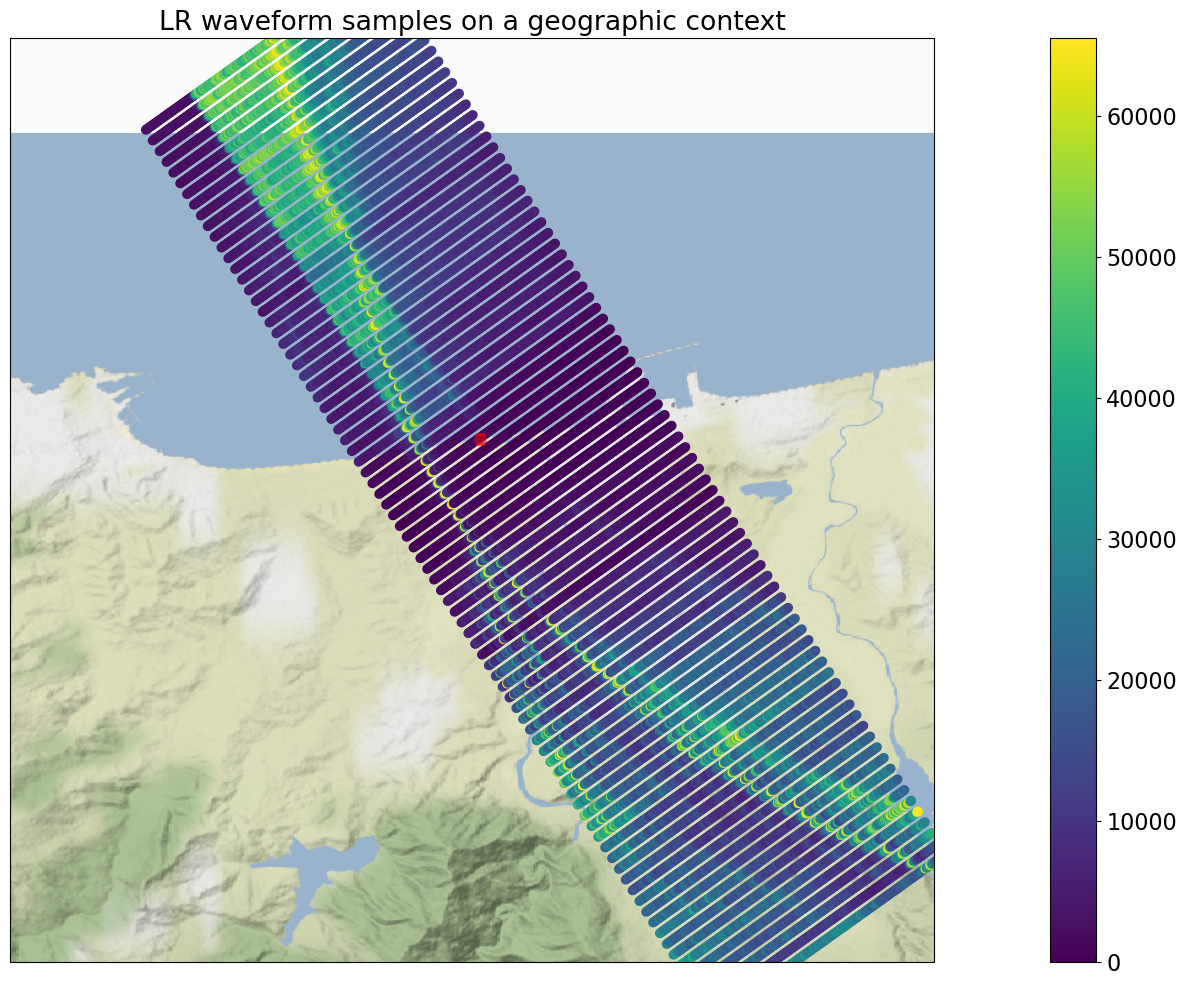

In [16]:
fig = plt.figure(figsize=(30,12))
ax = plt.axes(projection=cartopy.crs.PlateCarree(), aspect=1.25)
ax.set_extent(region, crs=cartopy.crs.PlateCarree())

ax.add_image(tiler, zoom)
p1 = ax.scatter(S6_vars["LR"]["x"], S6_vars["LR"]["y"], c=S6_vars["LR"]["waveforms_20hz_ku"][:, 0:256].T,
                vmin=0., vmax=65534)
p2 = ax.scatter(region_focus[0], region_focus[1], c='red', s=50, marker='s', alpha=0.5)
cbar = plt.colorbar(p1)
plt.title('LR waveform samples on a geographic context')

Same series of plots, but with the HR file

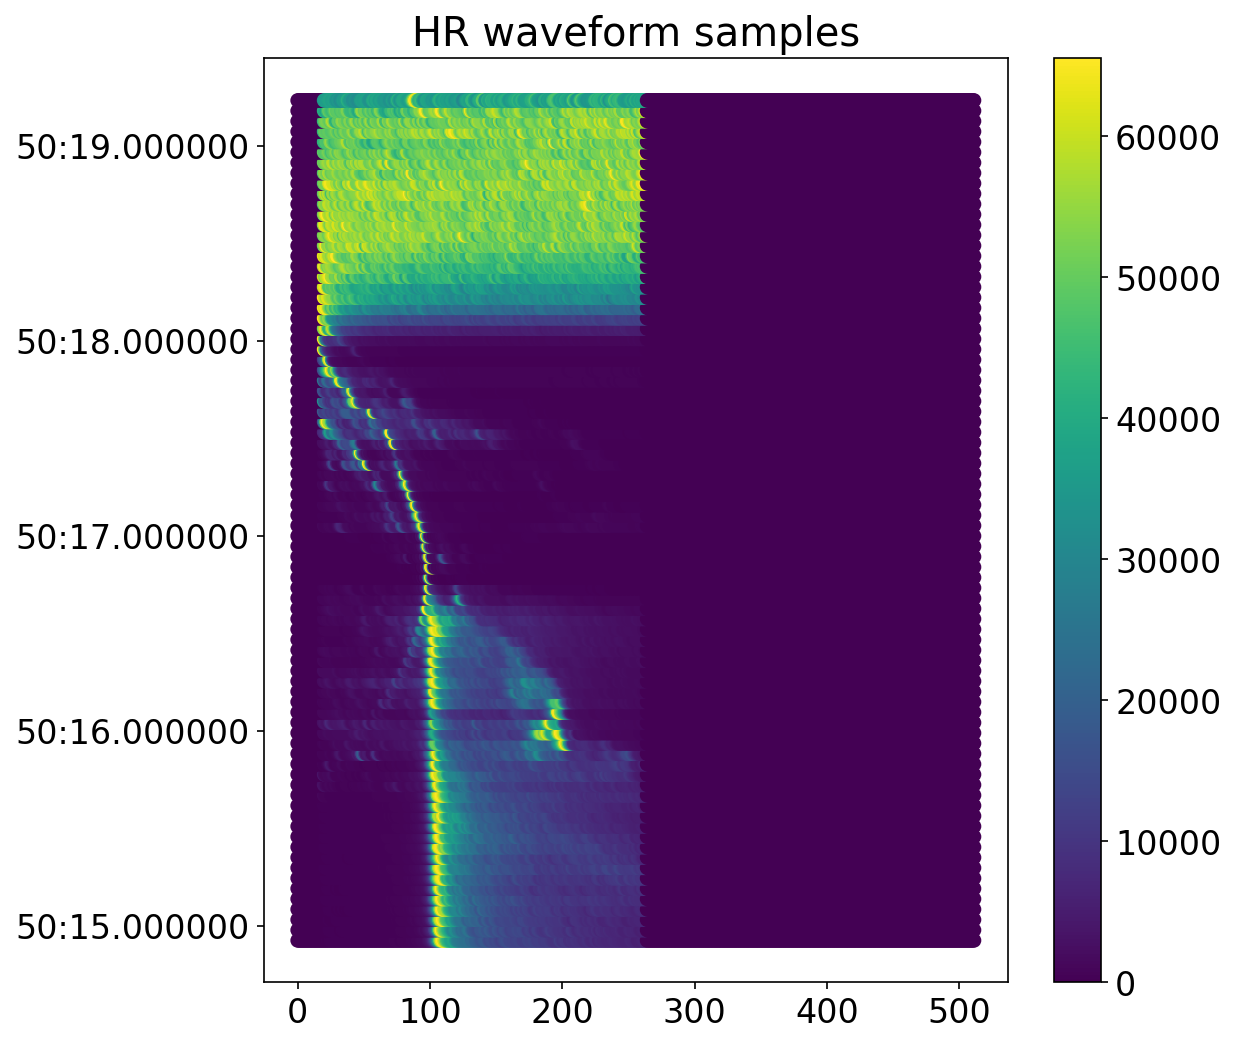

In [17]:
fig = plt.figure(figsize=(8, 8), dpi=dpi)
ax = plt.subplot(1,1,1)
p2 = ax.scatter(S6_vars["HR"]["samples2"], S6_vars["HR"]["time2"], c=S6_vars["HR"]["waveforms_20hz_ku"])

#colorbar
cbar = plt.colorbar(p2)
plt.title('HR waveform samples');

HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not FoundHTTP Error 404: Not Found

HTTP Error 404: Not Found


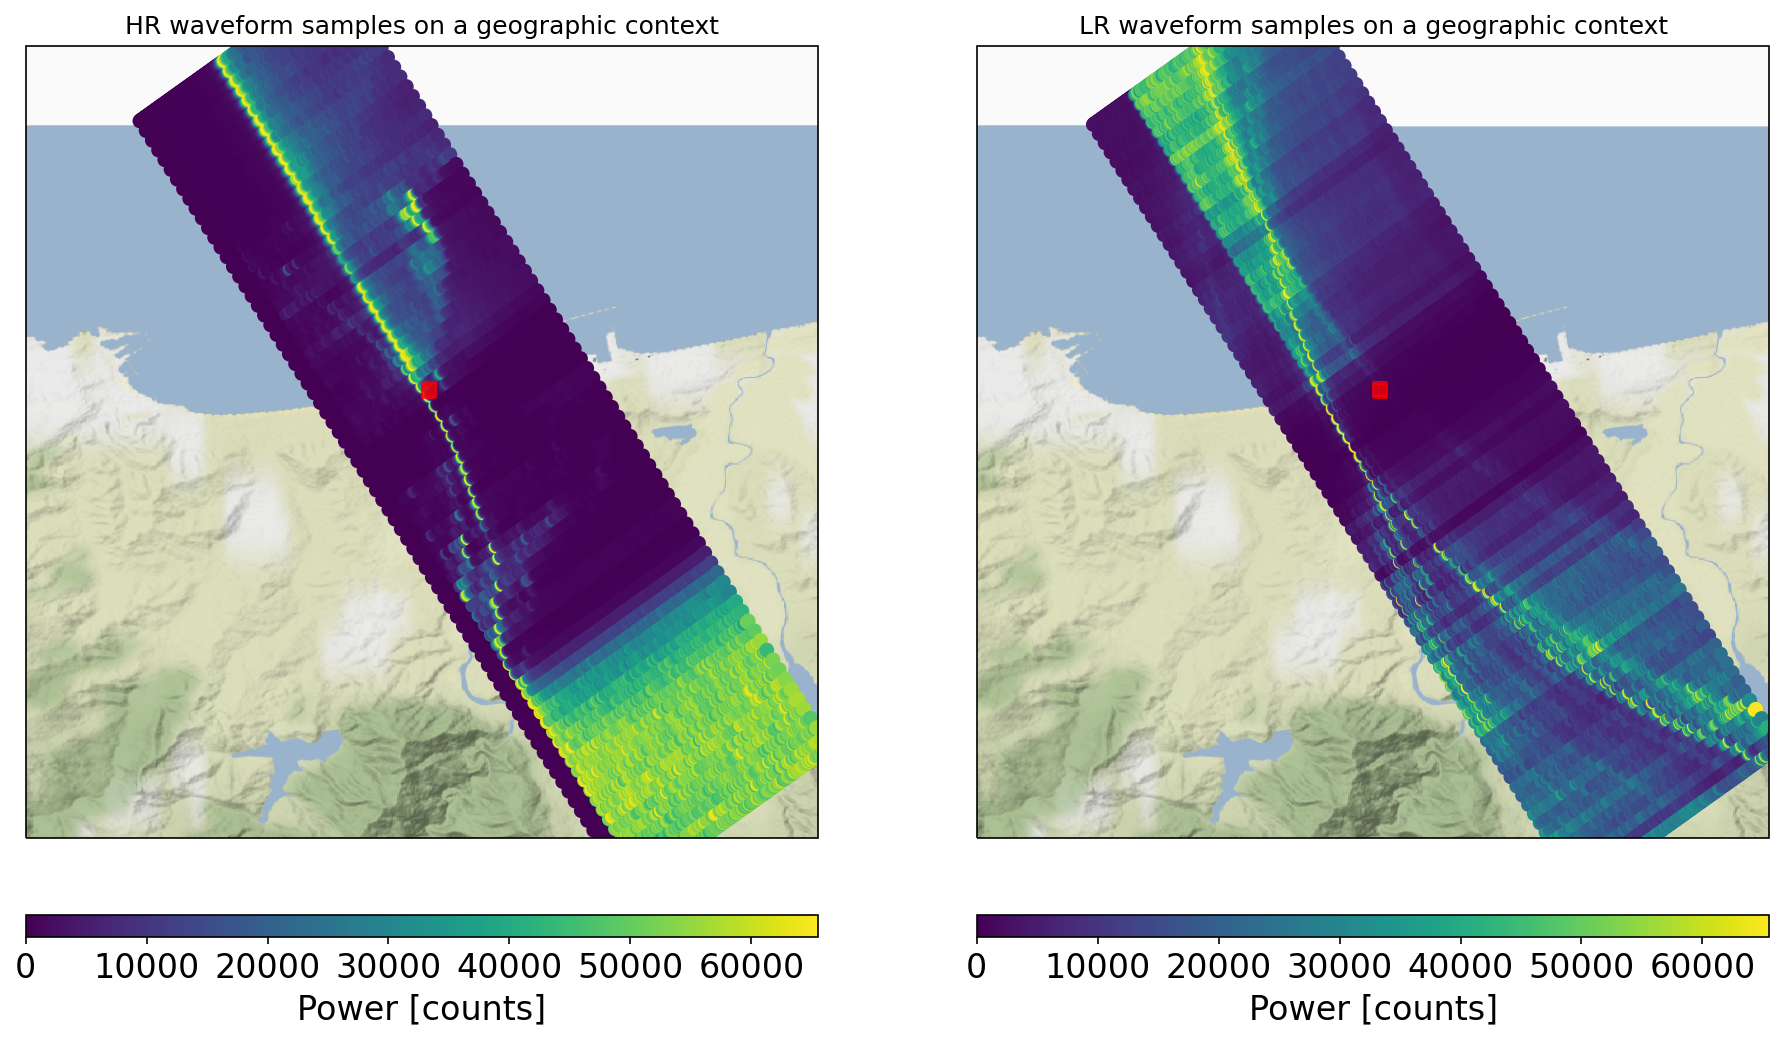

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 15), dpi=dpi, subplot_kw={"projection": cartopy.crs.PlateCarree()})

for m, resolution in zip(axes, ["HR", "LR"] ):

    p1 = m.scatter(S6_vars[resolution]["x"], S6_vars[resolution]["y"],
                   c=S6_vars[resolution]["waveforms_20hz_ku"][:, 0:256].T,
                    vmin=0., vmax=65534)

    p2 = m.scatter(region_focus[0], region_focus[1], c='red', s=50, marker='s', alpha=0.5)
    p3 = m.scatter(region_focus[0], region_focus[1], c='red', s=50, marker='s', alpha=0.5)

    m.set_extent(region, crs=cartopy.crs.PlateCarree())
    m.add_image(tiler, zoom)
    m.set_aspect(1.25)
    m.set_title(f'{resolution} waveform samples on a geographic context', fontsize=12)

    cb_ax = fig.add_axes([m.get_position().x0, 0.275, m.get_position().width, 0.01])
    cbar = fig.colorbar(p1, cax=cb_ax, orientation="horizontal", label="Power [counts]")

Text(0.5, 1.0, 'HR waveform samples on a geographic context')

HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found


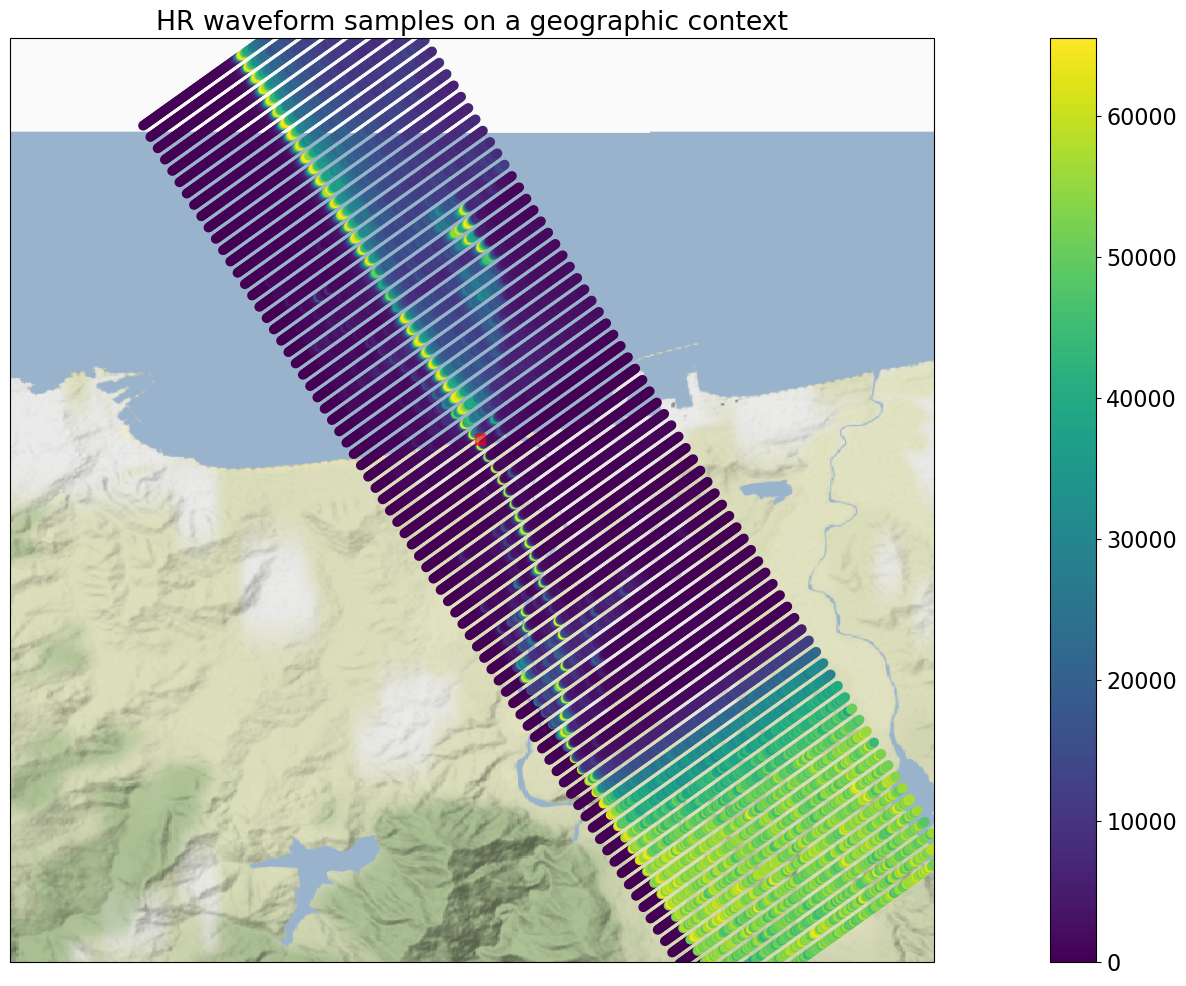

In [19]:
fig = plt.figure(figsize=(30,12))
ax = plt.axes(projection=cartopy.crs.PlateCarree(), aspect=1.25)

p1 = ax.scatter(S6_vars["HR"]["x"], S6_vars["HR"]["y"], c=S6_vars["HR"]["waveforms_20hz_ku"][:, 0:256].T,
                vmin=0., vmax=65534)
p2 = ax.scatter(region_focus[0], region_focus[1], c='red', s=50, marker='s', alpha=0.5)
ax.set_extent(region, crs=cartopy.crs.PlateCarree())
ax.add_image(tiler, zoom)

cbar = plt.colorbar(p1, ax=ax)
plt.title('HR waveform samples on a geographic context')

A look in 3D. 
Notice the small peaks in the first part ("noise"), before the leading edge

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Comparing the waveforms in 3D
[Back to top](#TOC_TOP)

</div>

/var/folders/p5/fdfmn2t168g0s422k3fb2zdw0000gn/T/ipykernel_39838/1774118666.py:9: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  m.azim = -30 ; m.dist = 10 ; m.elev = 15


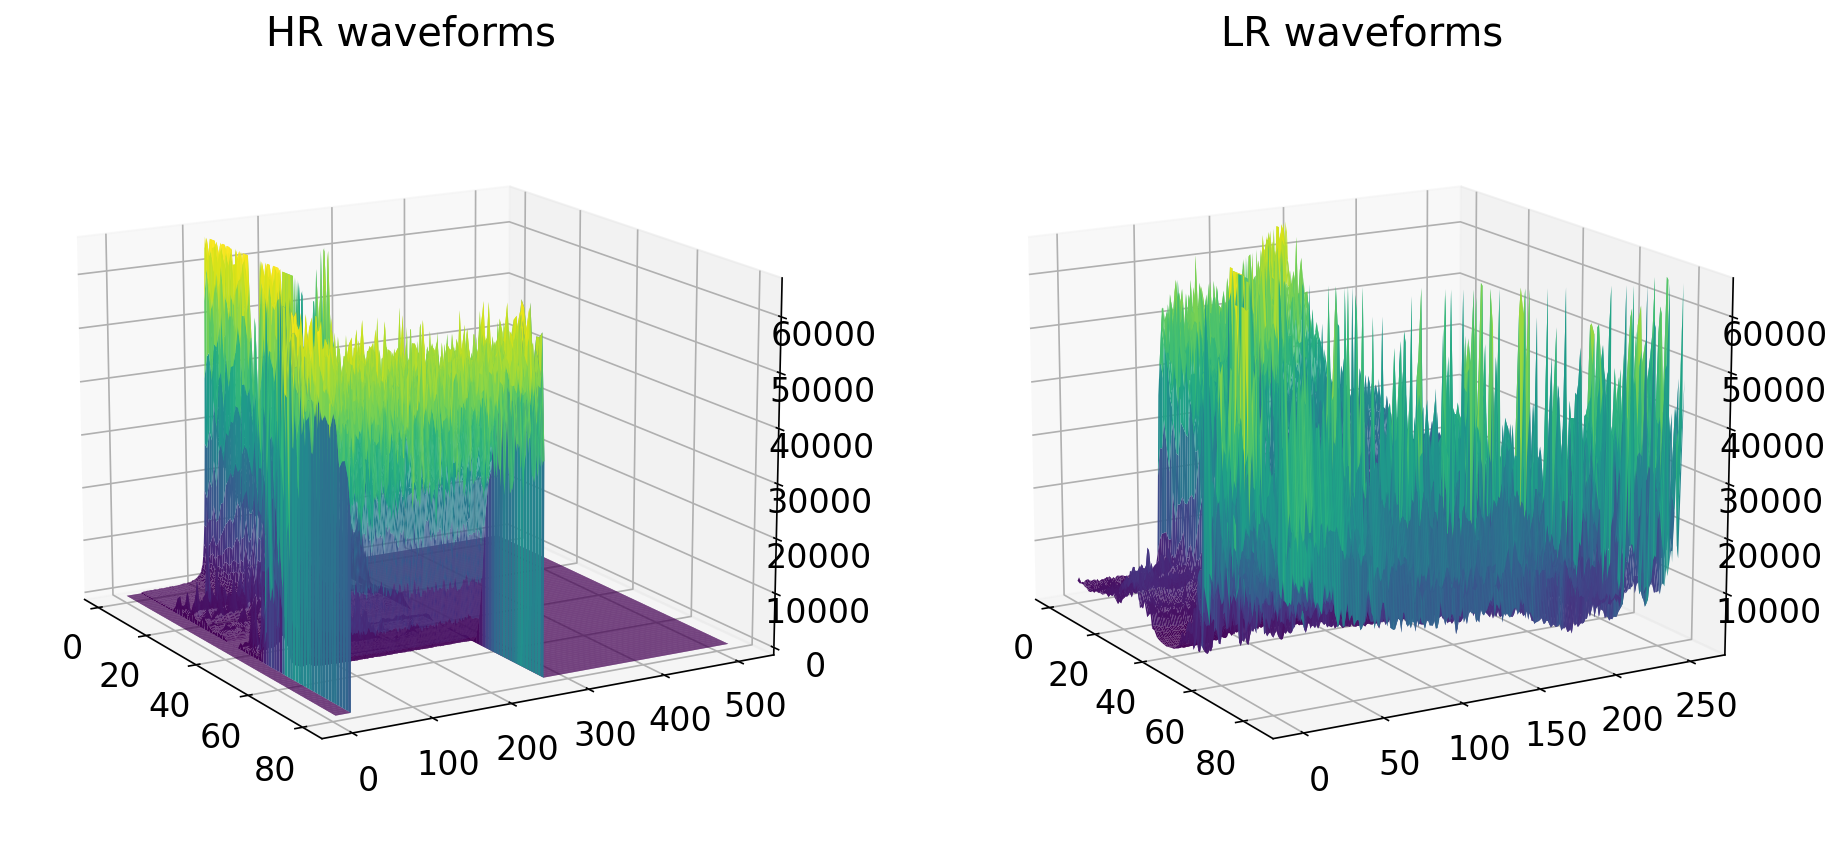

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 15), dpi=dpi, subplot_kw={"projection": "3d"})

for m, resolution in zip(axes, ["HR", "LR"] ):
    
    index = list(range(S6_vars[resolution]["time"].size))
    samples3, index3 = np.meshgrid(S6_vars[resolution]["samples"], index)

    #default: ax.azim = -60; ax.dist = 10; ax.elev = 30
    m.azim = -30 ; m.dist = 10 ; m.elev = 15
    m.plot_surface(index3, samples3, S6_vars[resolution]["waveforms_20hz_ku"], cmap='viridis', rstride=1, cstride=1)
    m.set_title(f'{resolution} waveforms')

<div class="alert alert-info" role="alert">

## <a id='section5'></a>5. Along track waveform evolution (for use in the Fort Boyard case)
[Back to top](#TOC_TOP)

</div>

We select only a few indexes around the Fort Boyard location and look at individual waveforms. 

In [21]:
subset_focus = S6_vars["LR"]["subset"].sel(time=((S6_vars["LR"]["lat_20"] > region_focus[1] - epsilon )
                                     & (S6_vars["LR"]["lat_20"] < region_focus[1] + epsilon)))

We will plot the waveforms left the one after the other - the things to look after are the small peaks before the leading edge. These are the effects of the radar wave bouncing on the top of the Fort Boyard before reflecting on the water. The top of the building is not a very good reflector, though, and a small one compared to the surrounding water, so those small peaks are indeed <em>small</em> - so we cut the top of the waveform off the plot, to see them better. 

In [22]:
%%capture
# initialise plot
fig, axes = plt.subplots(2, 1, figsize=(14, 7), dpi=dpi)
for ax in axes:
    ax.plot(subset_focus.variables['power_waveform'][0,:], linewidth=2, color='k')
axes[0].set_xticks([])
axes[0].set_facecolor('0.8')

# to better view the small peak in advance, we cut the waveforms
axes[1].set_ylim([0, 5000])
axes[1].set_xlim([0, 256])
axes[0].set_ylim([5000, 80000])
axes[0].set_xlim([0, 256])

# build animation function; clearing axes removes previous plot as quiver cannot natively update x/y, only UVC.
def animate(i):
    for ax in axes:
        ax.lines.pop(0)
        ax.plot(subset_focus.variables['power_waveform'][i, :], linewidth=2, color='k')

# animate
nbstepleft = 10
anim = FuncAnimation(fig, animate, interval=400, frames=nbstepleft)

In [23]:
HTML(anim.to_jshtml()) 

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./2_2_acquire_S6_full_cycle.ipynb" target="_blank"><< Acquiring a full Poseidon-4 cycle</a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>